# Basics of Hartree-Fock calculation in PySCF with H2 Molecule 

This notebook is an exercise in learning to use PySCF and how it defines various quantities in the self-consistent calculations. 

I use the hydrogen molecule $H_2$ in the minimial basis, and apply the Hartree-Fock theory to compute its molecular orbitals, orbital energies, the total ground state energy using PySCF. I also use the `ao2mo2` to obtain the one- and two-body integrals using PySCF. The notebook, and also PySCF conventions closely follow the textbook *Modern Quantum Chemistry* by Szabo and Ostlund [1]. 

The notebook helps me remember the following about PySCF:
* Define molecular geometry.
* Do SCF calculation.
* Get total energy, J & K matrices, core matrix, Fock matrix, and the overlap matrix.
* Get the molecular orbital (MO) coefficients.
* Use `ao2mo` get electron repulsion integrals (ERI) in atomic orbitals and transform them into various other basis, including MO.
* Use `ao2mo` to obtain the tensor form of the ERI.

## Fock-Operator and Molecular Orbitals

Recall Bohr radius, and 1 Hartree,

$$ a_0 = \frac{4\pi \epsilon_0\hbar^2}{m_e e^2}, \;\;\;
 E_0 = \frac{e^2}{4\pi \epsilon_0 a_0}. $$

Hamiltonian for the $H_2$ molecule within the Born-Oppenheimer approximation, 

$$ H = \sum_{i=1}^{2}\left[-\frac{1}{2}\nabla_i^2 - \sum_{A=1}^{2}\frac{1}{|\boldsymbol{R}_A-\boldsymbol{r}_i|}\right] + \frac{1}{|\boldsymbol{r}_1-\boldsymbol{r}_2|} + \frac{1}{|\boldsymbol{R}_1-\boldsymbol{R}_2|}. $$

The term in brackets is the one-electron Hamiltonian, which we denote as $\hat{h}$ below.

To specify a Hartree-Fock solution to the eigenstates of this system is to specify the electronic wavefunction as a *single* Slater determinant of the spin orbitals. When the same spatial orbitals are assigned to each spin, this is called the restricted Hartree-Fock state, and under this restriction, it can be shown (see Section 3.4.1 of [1]) that the spatial orbitals solve the eigenvalue equation, 

$$ \hat{f}(\boldsymbol{r}_1)\psi_a(\boldsymbol{r}_1) = \varepsilon_a \psi_a(\boldsymbol{r}_1),$$ 

where $\hat{f}$ is the Fock operator defined as,

$$ \hat{f}(1) = \hat{h}(1) + \sum_{a=1}^{N/2} 2 \hat{J}_a(1) - \hat{K}_a(1). $$

In the above equation, the Coulomb and Exchange operators $\hat{J}_a$ and $\hat{K}_a$ are,

$$ \hat{J}_a(1) = \int d\boldsymbol{r}_2 \psi_a^*(2)\frac{1}{r_{12}}\psi_a(2),$$
$$ \hat{K}_a(1)\psi_i(1) = \left[\int d\boldsymbol{r}_2 \psi_a^*(2)\frac{1}{r_{12}}\psi_i(2) \right]\psi_a(1).$$

## Basis Functions and Fock-Matrix 

Expand the molecular orbitals in terms of basis functions, which are typically a fixed family of functions (e.g. 1s orbitals) centered on the different atoms of the molecule. In general, 

$$ \psi_i(\boldsymbol{r}) = \sum_{\mu} C_{\mu i} \phi_{\mu}(\boldsymbol{r}).$$

The bases $\phi_\mu$ are not orthogonal in general. Substitution of this expansion into the Fock-operator eigenvalue equation above yields the generalized eigenvalue equation, 

$$ \mathbf{FC} = \mathbf{SC} \boldsymbol{\varepsilon}. $$

The overlap matrix, $\mathbf{S}$ is,

$$ S_{\mu\nu} = \int d\boldsymbol{r} \;\; \phi_\mu^*(\boldsymbol{r})\phi_\nu(\boldsymbol{r}). $$

The Fock matrix $\mathbf{F}=\mathbf{H}^{core} + \mathbf{G}$, where $\mathbf{H}^{core}$ is the matrix representation of $\hat{h}$, which contains the kinetic energy of one electron and its potential energy in the total nuclear potential of the molecule. The electron-electron interaction is contained in the matrix, 

$$ G_{\mu\nu} = \sum_{a}^{N/2} \sum_{\lambda\sigma} C_{\lambda a}C_{\sigma a}^* (2 V_{\mu\lambda,\nu\sigma}-V_{\mu\lambda,\sigma\nu}) \;\; = 
\sum_{\lambda\sigma} P_{\lambda\sigma}\left[ V_{\mu\lambda,\nu\sigma} - \frac{1}{2} V_{\mu\lambda,\sigma\nu} \right].
$$

The matrix $P$ is the density matrix, which is defined with a factor of 2 as in Eq. 3.144 in [1] for the closed shell RHF as,

$$
P_{\lambda\sigma} = 2\sum_{a}^{N/2}C_{\lambda a}C_{\sigma a}^* \rho_a,
$$

where $\rho_a$ is the occupancy of the orbital $a$.

The 2-body matrix elements in the expression for $G_{\mu\nu}$ define the Coulomb and exchange interactions and they correspond to the integral (see Eq. 3.155 in [1]), 

$$
V_{\mu\lambda,\nu\sigma} = \int d\boldsymbol{r}_1 \int d\boldsymbol{r}_2
\phi^*_\mu(\boldsymbol{r}_1)\phi^*_\lambda(\boldsymbol{r}_2)\frac{1}{|\boldsymbol{r}_1-\boldsymbol{r}_2|}
\phi_\nu(\boldsymbol{r}_1)\phi_\sigma(\boldsymbol{r}_2).
$$

The eigenvalues of the Fock operator are the orbital energies, $\varepsilon_a$, which is the energy of 1 electron in the mean-field of all other electrons. Thus each orbital corresponds to $N(N-1)$ electron interactions. The total energy of the system must divide this interaction by 2 in order to avoid counting twice when adding the orbital energies. As explained below Eq. 3.82 in [1],

$$
E_0 = \langle\Psi|H|\psi\rangle = \sum_{a=1}^{N} \langle a|\hat{h}|a\rangle + \frac{1}{2}\sum_{ab} V_{ab,ab},
$$

where $a$ are the MOs that solve the Fock matrix eigenvalue equation, and $V_{ab,ab}$ are the corresponding 2-body integrals as defined above but in the *orthogonal* molecular orbitals and not the atomic orbitals or basis functions. In terms of the matrices represented in the basis functions,

$$
E_0 = \mathrm{Tr}\left[\hat{\rho} H \right] = \frac{1}{2}\sum_{\mu\nu} P_{\mu\nu}\left( H^{core}_{\nu\mu} + F_{\nu\mu}\right).
$$

## Reference
[1] *Modern Quantum Chemistry* by Szabo and Ostlund 


In [1]:
import numpy as np
from scipy import linalg
from pyscf import gto, scf, ao2mo
from quantum.utils import plotting as PLT
from quantum import constants

**Step 1: Build H2 molecule** using the `gto` module.

In [2]:
bond_length = 0.74 # Angstrom
bond_length_bohr = bond_length * 1e-10 / (constants.bohr_radius)
print('Bond Length [bohr]',bond_length_bohr)
mol = gto.Mole()
mol.build(atom=f'H 0 0 {-bond_length/2};H 0 0 {bond_length/2}',basis='sto-3g',unit='A')

Bond Length [bohr] 1.3983973331193276


**Step 2: Solving via the restricted Hartree Fock method.**

The `RHF` function executes the SC procedure described in Section 3.4.6 in [1]. It also returns the total ground state energy including the nuclear repulsion energy. In Step 3 below, we will break down this energy into its various components.

In [3]:
# One-liner
sol = scf.RHF(mol).run()
# Alternatively, with kernel command
sol = scf.RHF(mol)
# Note that 'kernel' returns the SCF energy
Etot = sol.kernel()
print('Etot = ',Etot,'\n')
print('Check Nuclear Repulsion Energy: \n',
      '             1/R = ',1/bond_length_bohr,'\n',
      'sol.energy_nuc() = ',sol.energy_nuc())
print('MO coefficients (each MO in a column)\n',sol.mo_coeff,'\n')

converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
Etot =  -1.1167593073964255 

Check Nuclear Repulsion Energy: 
              1/R =  0.7151043385997851 
 sol.energy_nuc() =  0.7151043390810812
MO coefficients (each MO in a column)
 [[ 0.54884228  1.21245192]
 [ 0.54884228 -1.21245192]] 



$\mathbf{H}^{core}$, $J$, $K$, $\mathbf{S}$, and the Fock matrix $\mathbf{F}$

In [4]:
Hcore = sol.get_hcore()
J,K   = sol.get_jk()
F     = sol.get_fock()
S     = sol.get_ovlp()
print('Hcore:\n',Hcore,'\n')
print('J:\n',J,'\n')
print('K:\n',K,'\n')
print('S:\n',S,'\n')
print('Fock Matrix:\n',F,'\n')

Hcore:
 [[-1.12095946 -0.95937577]
 [-0.95937577 -1.12095946]] 

J:
 [[1.34575531 0.89426314]
 [0.89426314 1.34575531]] 

K:
 [[1.18164378 1.05837468]
 [1.05837468 1.18164378]] 

S:
 [[1.         0.65987312]
 [0.65987312 1.        ]] 

Fock Matrix:
 [[-0.36602603 -0.59429997]
 [-0.59429997 -0.36602603]] 



**Expression for Fock Matrix in terms of** $\mathbf{H}^{core}$, $J$, $K$
Confirm that $$\mathbf{F} = \mathbf{H}^{core} + \mathbf{J} - \frac{1}{2}\mathbf{K}.$$

In [5]:
print('Hcore + J - K/2 == Fock \n', np.all(Hcore + J - K/2 == F))

Hcore + J - K/2 == Fock 
 True


**Expression for Ground State Energy**
$$ E_0 = \langle\psi_a| \hat{h} + \hat{f} |\psi_b\rangle.$$

In [6]:
TotalElectronicEnergy = sol.mo_coeff[:,0].T @ (sol.get_hcore() + sol.get_fock()) @ sol.mo_coeff[:,0]
print('Total Electronic Energy = ',TotalElectronicEnergy)
print('+ Nuclear Repulsion     = ',TotalElectronicEnergy + 1/bond_length_bohr)
print('sol.e_tot               = ',sol.e_tot)


Total Electronic Energy =  -1.8318636464775064
+ Nuclear Repulsion     =  -1.1167593078777214
sol.e_tot               =  -1.1167593073964255


**Ground State Density Matrix**

In the ground state, the occupancy is only in the $a=0$ orbital since it can fill 2 spin states and thus account for all 2 electrons in the molecule:

$$ P_{\mu\nu} = 2 C_{\mu,0} C_{\nu,0}^*. $$

Note that this density matrix is $2\times2$ in the basis expansion. The reduction of MO to only $a=0$ comes from the fact that the occupancy $\rho_a = 0$ for all $a > 0$.

In [7]:
P = 2 * sol.mo_coeff[:,[0]] @ sol.mo_coeff[:,[0]].T
print('DM in Ground State\n',P,'\n')
print('DM from Ref [1]\n',1/(1+S[0,1])*np.ones((2,2)))

DM in Ground State
 [[0.60245569 0.60245569]
 [0.60245569 0.60245569]] 

DM from Ref [1]
 [[0.60245569 0.60245569]
 [0.60245569 0.60245569]]


**Potential energy surface as a function of Bond Length.**

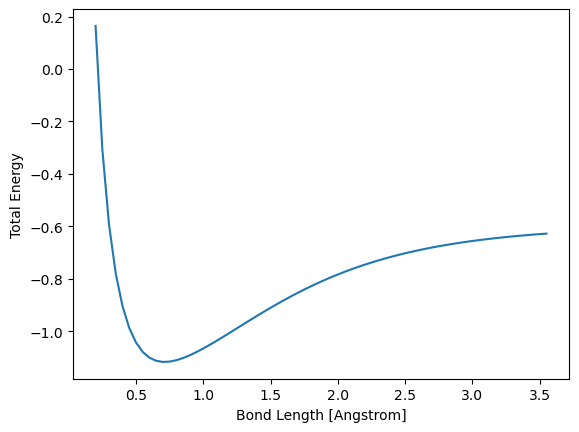

In [8]:
BondLengths = np.arange(0.2,3.6,0.05)
E = np.zeros(len(BondLengths))
for i,d in enumerate(BondLengths):
    mol = gto.Mole()
    mol.build(atom=f'H 0 0 {-d/2};H 0 0 {d/2}',basis='sto-3g',unit='A')
    rhf = scf.RHF(mol)
    rhf.verbose=0  
    rhf.kernel()  
    E[i] = rhf.e_tot
#
fig,ax=PLT.subplots(xlabel='Bond Length [Angstrom]',ylabel='Total Energy')
ax.plot(BondLengths,E)

## Coulomb Integrals

Here we use the module `ao2mo` to obtain the matrix elements $V_{\mu\lambda,\nu\sigma}$ in various basis. Note that PySCF uses the chemist notation so that 

$$ V_{pq,rs} = V^{\mathrm{PySCF}}_{ps,qr}.$$

The transformation back to physicist notation is made by transpose function.

The `ao2mo.restore` converts the 2e integrals (in Chemist's notation) between different level of permutation symmetry (8-fold, 4-fold, or no symmetry). This function accepts the contracted matrix notation produced by `ao2mo.kernel` to give the 4-tensor.

The `ao2mo.kernel` computes the 2-body electron repulsion integrals, and transforms to various bases specified as matrices with columns containing the basis vectors. First we produce the result in AO basis. Note that these basis are **not orthonormal** and therefore should not be used in the second quantized Hamiltonian. They will not correspond to canonical anti-commutation relations. 

In [9]:
Vtensor = ao2mo.restore(1,                       # 1 means do not use symmetry
                        ao2mo.kernel(            # Function that computes ERI
                            mol,                 # molecule defined above with gto.Mole
                            np.eye(2)),          # Original AO basis, i.e. make no transformation
                        2                        # Number of basis functions
                       )
# <pq | V | rs > = (ps|qr) = pyscfERI[p,s,q,r]
Vtensor = Vtensor.transpose((0,2,3,1))
Vtensor[Vtensor<1e-12] = 0
print('\nTensor Form:\n',Vtensor)


Tensor Form:
 [[[[7.74605944e-01 1.63878292e-03]
   [1.63878292e-03 1.29019963e-05]]

  [[1.63878292e-03 1.29019963e-05]
   [1.49063340e-01 1.63878292e-03]]]


 [[[1.63878292e-03 1.49063340e-01]
   [1.29019963e-05 1.63878292e-03]]

  [[1.29019963e-05 1.63878292e-03]
   [1.63878292e-03 7.74605944e-01]]]]


**ERI in MO basis**

In [10]:
Vtensor = ao2mo.restore(1,ao2mo.kernel(mol, sol.mo_coeff), sol.mo_coeff.shape[1])
# <pq | V | rs > = (ps|qr) = pyscfERI[p,s,q,r]
Vtensor = Vtensor.transpose((0,2,3,1))
Vtensor[Vtensor<1e-12] = 0
print('\nTensor Form:\n',Vtensor)


Tensor Form:
 [[[[0.16881849 0.        ]
   [0.         0.55400164]]

  [[0.         0.55400164]
   [0.81800984 0.        ]]]


 [[[0.         0.81800984]
   [0.55400164 0.        ]]

  [[0.55400164 0.        ]
   [0.         3.96390934]]]]


**ERI in orthogonalized bases**

Note that if we define new basis functions as

$$ \phi'_\mu = \sum_{\nu} X_\nu\mu \phi_\nu$$

where $ \mathbf{X} =\mathbf{S}^{-1/2}$, then the new functions are orthonormal. These are then good basis functions to expand the second quantized Hamiltonian, and they do not require the SCF solution for the molecule to first obtain MOs.

In [11]:
D,X = np.linalg.eigh(S)
Shalfinv = X @ np.diag(1/np.sqrt(D)) @ X.T
print('Check: S @ (Shalfinv @ Shalfinv) = I\n',S@Shalfinv@Shalfinv,'\n\n')

Vtensor = ao2mo.restore(1,ao2mo.kernel(mol, X), X.shape[1])
# # <pq | V | rs > = (ps|qr) = pyscfERI[p,s,q,r]
Vtensor = Vtensor.transpose((0,2,3,1))
Vtensor[Vtensor<1e-12] = 0
print('\nTensor Form:\n',Vtensor)

Check: S @ (Shalfinv @ Shalfinv) = I
 [[ 1.00000000e+00 -7.50116859e-17]
 [-1.69582215e-16  1.00000000e+00]] 



Tensor Form:
 [[[[0.45856998 0.        ]
   [0.         0.3127713 ]]

  [[0.         0.3127713 ]
   [0.46182174 0.        ]]]


 [[[0.         0.46182174]
   [0.3127713  0.        ]]

  [[0.3127713  0.        ]
   [0.         0.46512511]]]]
